# **Machine Learning Model for Predictive Maintenance for an Industrial Plant**

Industrial facilities often suffer from unplanned downtime leading to loss in productivity, high repair costs and safety risks. This solution uses AI algorithms to analyse an equipment data at any instance and predict if maintenance is needed or not. This helps reduce unplaned dowmtime and optimise processes

## Importing Necessary Libraries ##

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

## Loading dataset

In [3]:
#Loading dataset locally

data = pd.read_csv('/content/drive/MyDrive/realistic_predictive_maintenance_dataset.csv')
data.head()

,Vibration,Temperature,Pressure,RPM,Runtime,Maintenance Needed
0,0.649014,55.846293,31.788937,1251.301497,2132.615561,0
1,0.458521,65.793547,32.803923,1331.945688,1439.694652,0
2,0.694307,66.572855,35.415256,1724.188082,376.239934,0
3,0.956909,61.977227,35.269010,1683.111080,4337.139644,1
4,0.429754,68.387143,23.111653,1493.729522,4083.214945,0


## Exploratory Data Analysis##

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Vibration           100 non-null    float64
 1   Temperature         100 non-null    float64
 2   Pressure            100 non-null    float64
 3   RPM                 100 non-null    float64
 4   Runtime             100 non-null    float64
 5   Maintenance Needed  100 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 4.8 KB


In [5]:
counts = data['Maintenance Needed'].value_counts() #Checking the count of no maintenance(0) vs maintenance needed(1)
print(counts)

Maintenance Needed
0    93
1     7
Name: count, dtype: int64


**Observation**: There is no missing values or categorical data. Also, the dataset is an unbalanced.

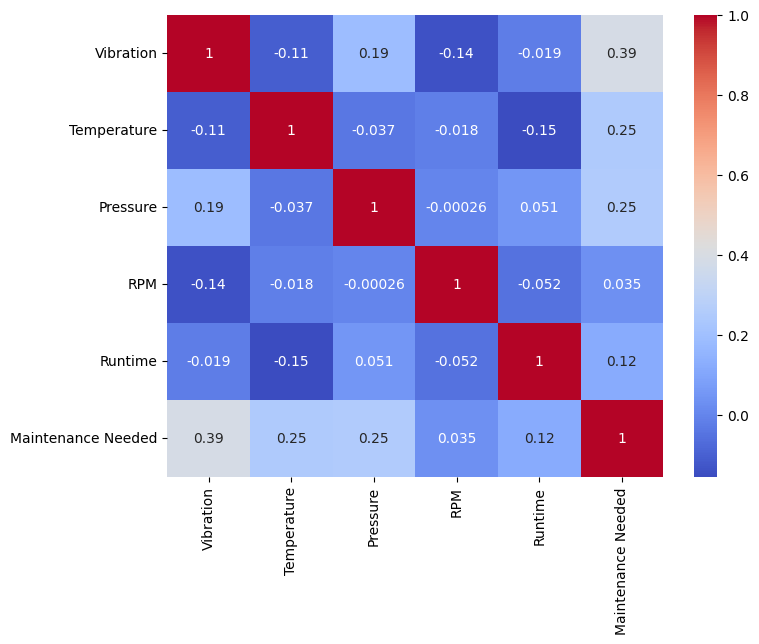

In [6]:
#Exploring correlation between features and maintenance needs

plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

**Observation:**
From the heatmap above, it is oberved that coreelation between features and target is low. This hints at the folllowing;

1. Features and target don't correlate individually in a linear way.
2. Non-linear patterns might exist. RandomForest and tree based models can detect this non-linear interaction.

## Model Building using Random Forest Classifier##

In [7]:
x = data.drop(columns=['Maintenance Needed'])
y = data['Maintenance Needed']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [8]:
#Using SMOTE to improve balance for more efficient model training

from collections import Counter
count = Counter(y_train) #Checking count of 1 and 0 in the training data
print(count)

Counter({0: 69, 1: 6})


In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
x_train, y_train = smote.fit_resample(x_train, y_train)

count_smote = Counter(y_train) #verifying new count of 1 and 0 in the training data
print(count_smote)

Counter({0: 69, 1: 69})


In [10]:
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

## Model Evaluation ##

In [11]:
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred, labels = model.classes_))
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.00      0.00      0.00         1

    accuracy                           0.92        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.92      0.92      0.92        25

[[23  1]
 [ 1  0]]
0.92
0.0
0.0
0.0


In [12]:
#The model is failing to catch '1' values, hence tuning threshold to improve true positive may solve the problem

y_probs = model.predict_proba(x_test)[:, 1]
y_pred_adjusted = (y_probs >= 0.3).astype(int)

In [13]:
#Checking metrics again

accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)
fscore = f1_score(y_test, y_pred_adjusted)

print(f"Acurracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1_Score: {fscore}")

cm = confusion_matrix(y_test, y_pred_adjusted)
cm

Acurracy: 0.96
Precision: 0.5
Recall: 1.0
F1_Score: 0.6666666666666666


array([[23,  1],
       [ 0,  1]])

## Performing more Model Evaluation

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

#ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
roc_auc

np.float64(0.9583333333333334)

In [15]:
#PR Curve and PR AUC
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
pr_auc

np.float64(0.5)

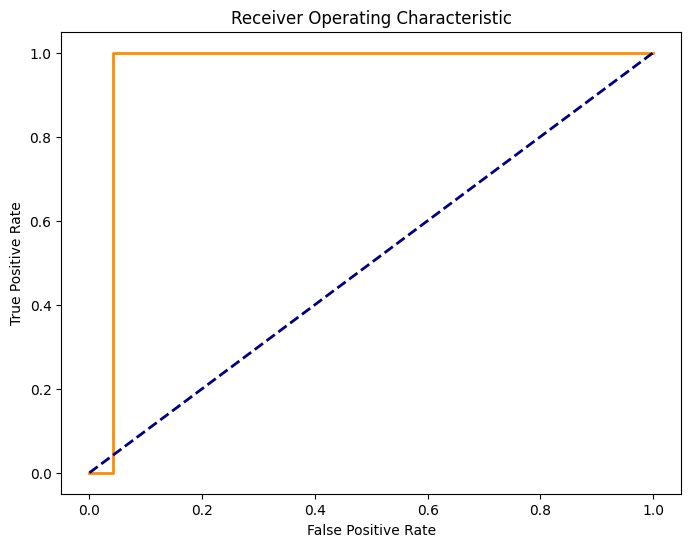

In [16]:
#Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve = {roc_auc: .2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

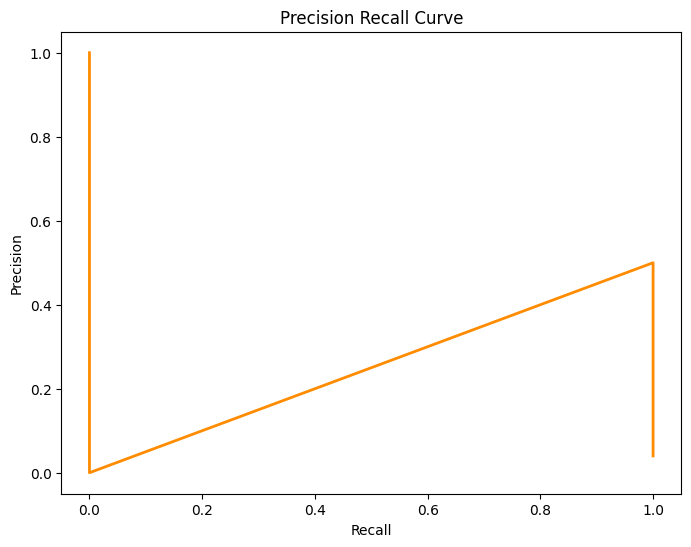

In [17]:
#Plot PR Curve

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve = {pr_auc: .2f}')
plt.legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

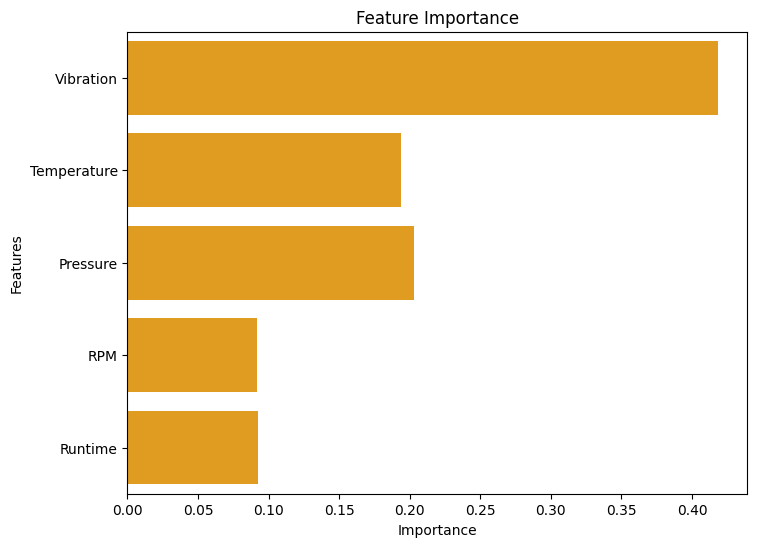

In [18]:
#Plot Feature Importance

feature_names = x.columns
importances = model.feature_importances_

plt.figure(figsize=(8,6))
sns.barplot(x=importances, y=feature_names, color = 'orange')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

##Saving model to create the Streamlit Interface

In [ ]:
import joblib
joblib.dump(model, 'model.joblib')

['model.joblib']

## **Conclusion** ##

This project focused on building a classification model for early failure detection in an equipment using a synthetic imbalanced dataset which which simulates real-world conditions. Techniques like SMOTE and threshold adjustment were used to address class imbalance with evaluation centered on accuracy, precision, recall and F1-score. The model achieved high recall though at the cost of prediction. Feature importance visualization ofered insight to key features influencing maintenance need prediction.


Future improvements can be made through more detailed and realiatic dataset, feature engineering and anomaly detection techniques.